# INF554 Kaggle Node2Vec Model
#### Francisco, Alex and Aksel

In [1]:
import random
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
import seaborn as sns
import os
import networkx as nx
import pdb
import pickle
from collections import Counter
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import text as fe
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
import datetime
import time
import keras
import lightgbm
import spacy
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
import nltk
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin

Using TensorFlow backend.


In [2]:
with open(r"training.txt", "r") as f:
    reader = csv.reader(f)
    training  = list(reader)
# in order of training examples
training = [element[0].split(" ") for element in training]
training = pd.DataFrame(training, columns=['Node1', 'Node2', 'Link'])
print("Training examples shape: {}".format(training.shape))

with open(r"testing.txt", "r") as f:
    reader = csv.reader(f)
    testing  = list(reader)
# in order of testing examples
testing = [element[0].split(" ") for element in testing]
testing = pd.DataFrame(testing, columns=['Node1', 'Node2'])
print("Testing examples shape: {}".format(testing.shape))

Training examples shape: (453797, 3)
Testing examples shape: (113450, 2)


In [3]:
if not os.path.exists(r'pickles'):
    os.mkdir(r'pickles')

In [4]:
'''
uncomment lines for reduced corpus with stopword removal. In future integrate stemmer here, multi-language
'''
NODE_INFO_DIRECTORY = r"node_information/text/"

corpus_path = r"pickles/simple_corpus.PICKLE" 
ids_path = r"pickles/ids.PICKLE"
if os.path.exists(corpus_path):
    with open(corpus_path, 'rb') as f:
        corpus = pickle.load(f)
    f.close()
    with open(ids_path, 'rb') as f:
        ids = pickle.load(f)
    f.close()
else:
    corpus = []
    ids = []
    for filename in tqdm(os.listdir(NODE_INFO_DIRECTORY), position=0, leave=True):
        with open(NODE_INFO_DIRECTORY + filename, 'r', encoding='UTF-8', errors='ignore') as f:
            doc_string = []
            for line in f:
                [doc_string.append(token.strip()) for token in line.lower().strip().split(" ") if token != ""]
            corpus.append(' '.join(doc_string))
            ids.append(filename[:-4])
    with open(corpus_path, '+wb') as f:
        pickle.dump(corpus, f)
    f.close()
    with open(ids_path, '+wb') as f:
        pickle.dump(ids, f)
    f.close() 

In [5]:
stemmed_corpus_path = r"pickles/stemmed_corpus.PICKLE" 
if os.path.exists(stemmed_corpus_path):
    with open(stemmed_corpus_path, 'rb') as f:
        stemmed_corpus = pickle.load(f)
    f.close()
else:
    print('Stemmed corpus unavailable')

# in order of alphabetical text information i.e. 0, 1, 10, 100
node_info = pd.DataFrame({'id': ids, 'corpus': corpus, 'stemmed': stemmed_corpus})
node_info_id = node_info.set_index(['id'])
print("Training node info shape: {}".format(node_info.shape))

Training node info shape: (33226, 3)


In [6]:
train_graph_split_path = 'pickles/train_graph_split.PICKLE'

if os.path.exists(train_graph_split_path):
    with open(train_graph_split_path, 'rb') as f:
        keep_indices = pickle.load(f)
    f.close()
else:
    keep_indices = random.sample(range(len(training)), k=int(len(training) * 0.05))
    with open(train_graph_split_path, '+wb') as f:
        pickle.dump(keep_indices, f)
    f.close()

data_train_val = training.iloc[keep_indices]
data_train = training.loc[~training.index.isin(keep_indices)]

In [7]:
linked_nodes = data_train.loc[data_train['Link']=='1']
linked_nodes = linked_nodes[['Node1', 'Node2']]
linked_nodes.to_csv('linked_nodes.txt', sep=' ', index=False, header=False)
graph=nx.read_edgelist('linked_nodes.txt', create_using=nx.Graph(), nodetype = str)

In [45]:
feature_vector_path = r"pickles/perf_val_data.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_val_data = pickle.load(f)
    f.close()

feature_vector_path = r"pickles/perf_test_data.PICKLE"
if os.path.exists(feature_vector_path):
    with open(feature_vector_path, 'rb') as f:
        perf_test_data = pickle.load(f)
    f.close()

In [9]:
from node2vec import Node2Vec
from gensim.models import Word2Vec

In [10]:
node2vec_path = r"pickles/NODE2VEC.PICKLE"
if os.path.exists(node2vec_path):
    print('Node2Vec already calculated')
else:
    x = ''
    while (x not in ['n', 'y']):
        x = input("Node2Vec object not available, recompute? y/n: ")
    if x == "y":
        # Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
        node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=1)

Node2Vec already calculated


In [11]:
node2vec_model_path = r"pickles/EMBEDDING_MODEL_FILENAME.model"
if os.path.exists(node2vec_model_path):
    model = Word2Vec.load(node2vec_model_path)
else:
    x = ''
    while (x not in ['n', 'y']):
        x = input("Word2Vec model not available, recompute? y/n: ")
    if x == "y":
        # Embed nodes
        model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed
        # Save embeddings for later use
        model.wv.save_word2vec_format('pickles/EMBEDDING_FILENAME.embed')
        # Save model for later use
        model.save('pickles/EMBEDDING_MODEL_FILENAME.model')

In [12]:
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [13]:
embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:43<00:00, 522.63it/s]


In [14]:
embed_size = len(edges_embs[('0', '1')])
df_test = pd.DataFrame(0, index=np.arange(len(testing)), columns=range(embed_size))
j = []
for i in tqdm(range(len(testing)), position=0, leave=True):
    try:
        df_test.loc[i] = edges_embs[(testing.loc[i]['Node1'], testing.loc[i]['Node2'])]
    except:
        df_test.loc[i] = np.zeros(embed_size)

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [03:26<00:00, 549.66it/s]


In [54]:
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [55]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9309566787003611


In [56]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(df_test)

In [47]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("AverageEmbeder_node2vec_prediction.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

## Boosting Node2Vec with simple features

In [48]:
extended_model_train = pd.concat([perf_val_data, df_train], axis =1)
extended_model_test = pd.concat([perf_test_data, df_test], axis =1)
extended_model_test

,Node1,Node2,original_index,tfidf_similarity,languages_similarity,joint_length,file_distance,common_neighbors,jaccard_coefficient,shortest_path,...,54,55,56,57,58,59,60,61,62,63
0,870,10284,0,0.020013,0.472353,2082371091,9414,0,0.000000,4,...,0.682929,2.761880,0.244700,-6.084877,6.286168,-2.657356,-2.966777,2.155311,0.804951,0.605295
1,620,15300,1,0.302197,0.968905,10964800,14680,12,0.044444,3,...,-1.682803,0.780734,-1.965949,-1.003307,0.188083,-5.698223,4.742330,0.585908,1.838359,3.553890
2,21115,31904,2,0.005682,0.976566,3102536,10789,0,0.000000,4,...,1.288029,-0.579455,1.404730,-1.514296,0.744953,4.597077,0.311776,-0.856986,-0.436704,1.654195
3,3021,28396,3,0.001427,0.438494,26860638,25375,0,0.000000,4,...,1.840344,1.492758,-2.146064,-2.758919,6.628351,-0.308831,2.672504,-0.499439,1.684016,0.930467
4,10780,6135,4,0.035456,0.524943,501323778,4645,8,0.177778,3,...,-3.180443,-1.906920,-1.674759,-0.000875,1.714788,-1.282201,-1.873245,-3.128888,1.393322,0.452016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113445,13419,13751,113445,0.038824,0.992118,1483618868,332,1,0.071429,3,...,-3.664458,-2.484407,-3.427358,-1.538757,-2.335713,-0.947735,-1.429542,-3.910299,4.516082,2.173953
113446,16696,20191,113446,0.000000,0.000000,319676,3495,0,0.000000,5,...,-2.919244,1.225435,-2.698772,-0.842231,-1.885366,0.277235,0.292737,3.812270,-2.406736,-0.085662
113447,10654,27692,113447,0.002498,0.269025,62737199,17038,0,0.000000,4,...,0.341870,-0.719824,-2.205982,-2.307344,4.334990,-2.287159,0.479497,-2.842239,-4.361457,0.681090
113448,5409,1668,113448,0.071846,0.992244,90309525,3741,6,0.027650,3,...,3.623226,-1.974130,-0.115279,-1.022006,-4.620026,-0.687236,0.385465,-0.534603,-0.936587,-1.095154


In [73]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in extended_model_train.columns if i not in d_columns]
X = extended_model_train[cols]

y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [74]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.949361313868613


In [75]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model_lgbm.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

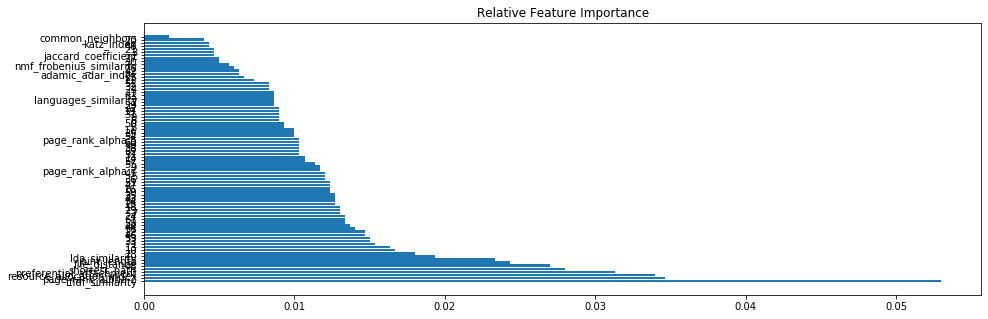

In [76]:
importance = np.array(features.values.reshape(-1))
importance = list(importance/importance.sum(axis=0,keepdims=1))

bars = list(features.index.values)

y_pos = np.arange(len(bars))

fig, ax = plt.subplots(figsize=(15,5))

# Create horizontal bars
plt.barh(y_pos, importance)

# Create names on the y-axis
plt.yticks(y_pos, bars)
# Add title
plt.title("Relative Feature Importance")

# Show graphic
plt.show()

In [60]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(extended_model_test[cols])

In [72]:
final_pred = pd.concat([pd.DataFrame(np.arange(len(df_test))), pd.DataFrame(predictions)],axis=1)
final_pred.columns = ['id', 'predicted']
with open("AverageEmbeder_augmented_ensemble_prediction.csv","+w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for index, row in final_pred.iterrows():
        csv_out.writerow(row)

In [62]:
d_columns = ['original_index', 'Link', 'Node1', 'Node2']
cols = [i for i in perf_val_data.columns if i not in d_columns]
X = perf_val_data[cols]
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

0.9423296102119899


In [69]:
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X, y)
predictions = model_lgbm.predict(extended_model_test[cols])

## Creating simple ensemble

In [61]:
extended_features_predictions = predictions

In [57]:
node2vec_predictions = predictions

In [70]:
simple_predictions = predictions

In [71]:
predictions = np.array([int(i) for i in ((simple_predictions + node2vec_predictions + extended_features_predictions) >= 2)])
predictions



array([1, 1, 0, ..., 0, 1, 1])

In [68]:
len(simple_predictions)

3404

In [102]:
print(f1_score(y_test, predictions))

0.9482523831139356


In [118]:
sum(simple_predictions == node2vec_predictions)

99869

In [119]:
sum(extended_features_predictions == node2vec_predictions)

102331

In [120]:
sum(simple_predictions == extended_features_predictions)

109126

## Testing best model

In [23]:
node2vec_path = r"pickles/NODE2VEC.PICKLE"
if os.path.exists(node2vec_path):
    with open(node2vec_path, 'rb') as f:
        node2vec = pickle.load(f)
    f.close()

In [24]:
model = node2vec.fit(window=20, min_count=25, batch_words=10)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:49<00:00, 456.48it/s]


0.9111969111969113


In [25]:
model = node2vec.fit(window=5, min_count=20, batch_words=10)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [01:06<00:00, 339.83it/s]


0.909952606635071


In [26]:
model = node2vec.fit(window=10, min_count=40, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:46<00:00, 489.57it/s]


0.9146204100022527


In [27]:
model = node2vec.fit(window=5, min_count=40, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:59<00:00, 382.90it/s]


0.909952606635071


In [28]:
model = node2vec.fit(window=40, min_count=40, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:52<00:00, 433.22it/s]


0.9010592742844264


In [29]:
model = node2vec.fit(window=10, min_count=40, batch_words=2)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:50<00:00, 450.44it/s]


0.9146204100022527


In [31]:
model = node2vec.fit(window=15, min_count=40, batch_words=1)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:50<00:00, 447.07it/s]


0.9111411817771764


In [32]:
model = node2vec.fit(window=10, min_count=100, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:54<00:00, 417.62it/s]


0.9146204100022527


In [38]:
from node2vec.edges import WeightedL1Embedder
from node2vec.edges import WeightedL2Embedder
from node2vec.edges import AverageEmbedder
from node2vec.edges import HadamardEmbedder

In [39]:
#edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
edges_embs = WeightedL1Embedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:58<00:00, 389.13it/s]


0.8150208623087621


In [40]:
edges_embs = WeightedL2Embedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:52<00:00, 430.60it/s]


0.8150208623087621


In [41]:
edges_embs = AverageEmbedder(keyed_vectors=model.wv)

embed_size = len(edges_embs[('0', '1')])
df_train = pd.DataFrame(0, index=np.arange(len(data_train_val)), columns=range(embed_size))
j = []
for j, i in tqdm(enumerate(data_train_val.index), position=0, leave=True, total = len(data_train_val)):
    try:
        df_train.loc[j] = edges_embs[(data_train_val.loc[i]['Node1'], data_train_val.loc[i]['Node2'])]
    except:
        df_train.loc[j] = np.zeros(embed_size)
X = df_train
y = data_train_val['Link']
y = list(map(lambda i: int(i), y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
lgbm = lightgbm.LGBMClassifier()
model_lgbm = lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
print(f1_score(y_test, predictions))

100%|███████████████████████████████████████████████████████████████████████████| 22689/22689 [00:55<00:00, 408.52it/s]


0.9309566787003611


In [43]:
embed_size = len(edges_embs[('0', '1')])
df_test = pd.DataFrame(0, index=np.arange(len(testing)), columns=range(embed_size))
j = []
for i in tqdm(range(len(testing)), position=0, leave=True):
    try:
        df_test.loc[i] = edges_embs[(testing.loc[i]['Node1'], testing.loc[i]['Node2'])]
    except:
        df_test.loc[i] = np.zeros(embed_size)

100%|█████████████████████████████████████████████████████████████████████████| 113450/113450 [04:55<00:00, 383.91it/s]
